In [1]:
import numpy as np 
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from pyresample import kd_tree, geometry
import scipy.io as sio
src_dir = os.environ.get('srcdir')
sys.path.append(src_dir)
from features.mask_roms_uvp import uvp_masks

In [2]:
#get roms grid
R_grid_path = os.path.join(os.environ.get('intdir'),'waom10_grd_raw.nc')
print('load ',R_grid_path)
R_grid = xr.open_dataset(R_grid_path)

out_path = os.path.join(os.environ.get('intdir'),'waom10_grd_patched.nc')

load  /home/ubuntu/bigStick/tidal_melting/data/preprocessing/interim/waom10_grd_raw.nc


In [3]:
#get TISOM patch
T_grid_path = os.path.join(os.environ.get('extdir'),'gwyther','tisom008_grd.nc')
print('load ',T_grid_path)
T_grid = xr.open_dataset(T_grid_path)

load  /home/ubuntu/bigStick/tidal_melting/data/preprocessing/external/gwyther/tisom008_grd.nc


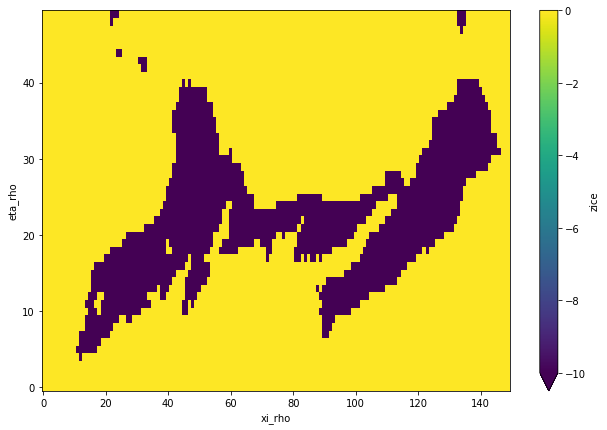

In [12]:
#T_grid_sel = T_grid.isel(eta_rho=slice(0,50),xi_rho=slice(125,275))
plt.close()
T_grid_sel.zice.plot(size=7,vmin=-10,vmax=0)
plt.show()

In [11]:
#remove shallow fast ice
T_grid_sel.zice.values[T_grid_sel.zice.values > -10] = 0 

In [15]:
amundsen_fix_path = os.path.join(os.environ.get('extdir'),'millan','Bathymetry_ASE_Millan_et_al_2017.nc')
print('load ',amundsen_fix_path)
amu_fix = xr.open_dataset(amundsen_fix_path)

amundsen_fix_latlon_path = os.path.join(os.environ.get('extdir'),'millan','lon_lat_romain_grid.mat')

load  /home/ubuntu/bigStick/tidal_melting/data/preprocessing/external/millan/Bathymetry_ASE_Millan_et_al_2017.nc


In [16]:
print('resample TISOM')
T_def = geometry.SwathDefinition(lons=T_grid_sel.lon_rho.values,lats=T_grid_sel.lat_rho.values)
R_def = geometry.SwathDefinition(lons=R_grid.lon_rho.values,lats=R_grid.lat_rho.values)

resample TISOM


In [17]:
#resample tisom
T_res = {}
for var in ['h','zice','mask_rho']:#,'mask_u','mask_v','mask_psi']:
    T_res[var] = kd_tree.resample_nearest(T_def,T_grid_sel[var].values,R_def,10000,fill_value=None,nprocs=16)

In [18]:
#resample boundary lats and lon for later smoothing
T_def = geometry.SwathDefinition(lons=T_grid_sel.lon_rho[:,[0,-1]].values,lats=T_grid_sel.lat_rho[:,[0,-1]].values)
T_res['lon_we'] = kd_tree.resample_nearest(T_def,T_grid_sel.lon_rho[:,[0,-1]].values,R_def,10000,fill_value=None,nprocs=16)

T_def = geometry.SwathDefinition(lons=T_grid_sel.lon_rho[[0,-1]].values,lats=T_grid_sel.lat_rho[[0,-1]].values)
T_res['lon_sn'] = kd_tree.resample_nearest(T_def,T_grid_sel.lon_rho[[0,-1]].values,R_def,10000,fill_value=None,nprocs=16)

In [19]:
from scipy.interpolate import LinearNDInterpolator

def NDinterp(data):

    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = LinearNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

    return filled

In [20]:
#add tisom in waom grid
R_new = R_grid.copy()
for var in ['h','zice','mask_rho']:
    print('')

    R_new[var].values[~T_res[var].mask]=T_res[var].data[~T_res[var].mask]
    R_new[var].values[~T_res['lon_sn'].mask]=np.nan
    R_new[var].values[~T_res['lon_we'].mask]=np.nan
    
    R_new[var].values = NDinterp(R_new[var].values)
    
R_new.mask_rho.values[R_new.mask_rho.values<0.5]=0
R_new.mask_rho.values[R_new.mask_rho.values>=0.5]=1

In [21]:
#get amundsen patch and prepare lat lon coords
print('resample amundsen')
amu_fix_latlon = sio.loadmat(amundsen_fix_latlon_path)
amu_lon = amu_fix_latlon['lone']
amu_lat = amu_fix_latlon['late']
amu_lon[amu_lon>180]-=360.0

resample amundsen


In [22]:
A_res = {}
A_def = geometry.SwathDefinition(lons=amu_lon,lats=amu_lat)
R_def = geometry.SwathDefinition(lons=R_grid.lon_rho.values,lats=R_grid.lat_rho.values)
A_res['h'] = kd_tree.resample_nearest(A_def,-amu_fix.BED.values,R_def,10000,fill_value=None,nprocs=16)

In [23]:
#resample boundary lats and lon for later smoothing
A_def = geometry.SwathDefinition(lons=amu_lon[:,[0,-1]],lats=amu_lat[:,[0,-1]])
A_res['lon_we'] = kd_tree.resample_nearest(A_def,-amu_fix.BED.values[:,[0,-1]],R_def,10000,fill_value=None,nprocs=16)

A_def = geometry.SwathDefinition(lons=amu_lon[[0,-1]],lats=amu_lat[[0,-1]])
A_res['lon_sn'] = kd_tree.resample_nearest(A_def,-amu_fix.BED.values[[0,-1]],R_def,10000,fill_value=None,nprocs=16)

In [24]:
R_new['h'].values[~A_res['h'].mask]=A_res['h'].data[~A_res['h'].mask]
R_new['h'].values[~A_res['lon_sn'].mask]=np.nan
R_new['h'].values[~A_res['lon_we'].mask]=np.nan

R_new['h'].values = NDinterp(R_new['h'].values)

#R_new.mask_rho.values[(R_new.h+R_new.zice).values<20.0]=0
#R_new.mask_rho.values[(R_new.h+R_new.zice).values<20.0]=0

In [25]:
bed = R_new.h.values.copy()
ice = R_new.zice.values.copy()
#set bed minimum depth to 10 cm
bed[bed<0.1]= 0.1
#set ice draft at these places to zero 
ice[bed<0.1] = 0.0

#set water column thickness to a small positive value (ROMS don't like when bed = ice draft)
wct = (bed+ice).copy()
ice[wct==0] = -bed[wct==0] + 0.1

R_new.h.values = bed.copy()
R_new.zice.values = ice.copy()
R_new.mask_rho.values[wct<20.0]=0

In [26]:
R_new.mask_u.values,R_new.mask_v.values,R_new.mask_psi.values = uvp_masks(R_new.mask_rho.values)

In [27]:
print('write to ',out_path)
R_new.to_netcdf(out_path)

write to  /home/ubuntu/bigStick/tidal_melting/data/preprocessing/interim/waom10_grd_patched.nc
